# 젠더 법안 K-means

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
gender = pd.read_csv('./16th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
gender = gender.drop('level_0',1)
print(gender.shape)

(96, 10)


In [4]:
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,163169,정당법중개정법률안,2004-03-02,위원장,2004-03-09,원안가결,제16대 (2000~2004) 제245회,가. 제244회 국회(임시회) 제6차 본회의(2004. 1. 8)에서 정치개혁...,정치개혁특별위원회,[]
1,163156,성매매알선등행위의처벌에관한법률안,2004-02-26,위원장,2004-03-02,원안가결,제16대 (2000~2004) 제245회,가. 2002년 9월 11일 조배숙의원외 85인이 발의한 성매매알선등행위의처벌...,법제사법위원회,[]
2,163106,정부조직법중개정법률안,2004-01-20,정부,2004-03-02,대안반영폐기,제16대 (2000~2004) 제245회,각종 재난에 대한 예방·대응 복구기능을 강화하고 효율적인 안전관리체제를 구축...,행정자치위원회,[]
3,163094,영유아보육법개정법률안,2003-12-27,위원장,2004-01-08,수정가결,제16대 (2000~2004) 제244회,1. 제229회국회(임시회) 제1차 위원회(2002. 4. 15) 제238회...,보건복지위원회,[]
4,163077,건강가정기본법안,2003-12-26,위원장,2003-12-29,원안가결,제16대 (2000~2004) 제244회,1. 제242회국회(임시회) 제1차 위원회(2003. 8. 25) 제243회...,보건복지위원회,[]


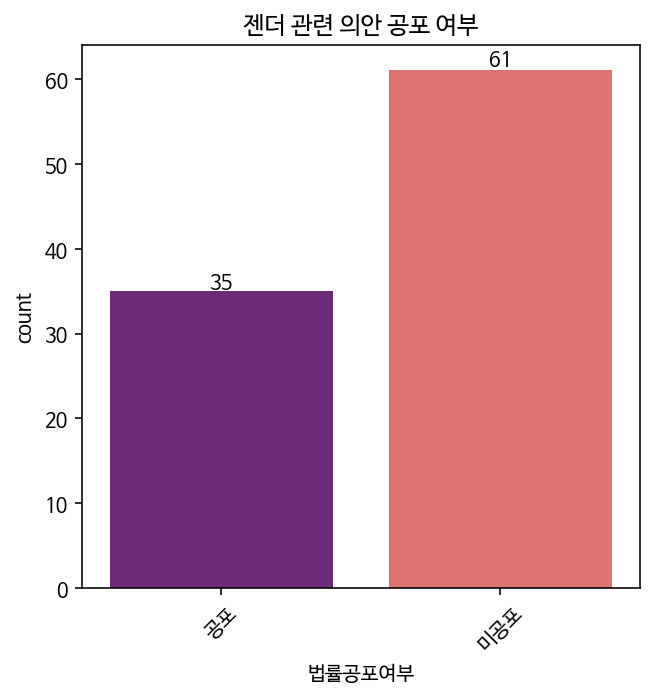

In [5]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [6]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [7]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [8]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 12.3 ms, sys: 142 µs, total: 12.5 ms
Wall time: 12.8 ms


In [9]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [10]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 20.4 s, sys: 446 ms, total: 20.9 s
Wall time: 11.3 s


0    [정당법중개정법률, 국회, 임시회, 본회, 정치개혁특별위원회, 구성, 국회, 임시회...
1    [성매매알선등행위의처벌에관한법률안, 조배숙의원, 발의, 성매매알선등행위의처벌방지에관...
2    [정부조직법중개정법률, 각종, 재난, 예방, 대응, 복구기능, 강화, 효율적, 안전...
Name: tokens, dtype: object

In [11]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 29 ms, sys: 1.9 ms, total: 30.9 ms
Wall time: 36.3 ms


In [12]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 848 µs, sys: 73 µs, total: 921 µs
Wall time: 873 µs


In [13]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(95, 13)


In [14]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [15]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-27 00:00:39,418 : INFO : collecting all words and their counts
2020-09-27 00:00:39,419 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-27 00:00:39,422 : INFO : collected 3473 word types from a corpus of 11516 raw words and 95 sentences
2020-09-27 00:00:39,423 : INFO : Loading a fresh vocabulary
2020-09-27 00:00:39,427 : INFO : effective_min_count=10 retains 211 unique words (6% of original 3473, drops 3262)
2020-09-27 00:00:39,429 : INFO : effective_min_count=10 leaves 4717 word corpus (40% of original 11516, drops 6799)
2020-09-27 00:00:39,433 : INFO : deleting the raw counts dictionary of 3473 items
2020-09-27 00:00:39,434 : INFO : sample=0.001 downsamples 141 most-common words
2020-09-27 00:00:39,435 : INFO : downsampling leaves estimated 2958 word corpus (62.7% of prior 4717)
2020-09-27 00:00:39,436 : INFO : estimated required memory for 211 words and 100 dimensions: 274300 bytes
2020-09-27 00:00:39,437 : INFO : resetting layer weights
202

2020-09-27 00:00:39,769 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:39,770 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:39,771 : INFO : EPOCH - 15 : training on 11516 raw words (2946 effective words) took 0.0s, 445673 effective words/s
2020-09-27 00:00:39,776 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:39,781 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:39,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:39,785 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:39,786 : INFO : EPOCH - 16 : training on 11516 raw words (2970 effective words) took 0.0s, 306370 effective words/s
2020-09-27 00:00:39,798 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:39,801 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-09-27 00:00:40,071 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,074 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,075 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,076 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,077 : INFO : EPOCH - 32 : training on 11516 raw words (3002 effective words) took 0.0s, 294183 effective words/s
2020-09-27 00:00:40,084 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,086 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,089 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,090 : INFO : EPOCH - 33 : training on 11516 raw words (2935 effective words) took 0.0s, 449868 effective words/s
2020-0

2020-09-27 00:00:40,302 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,304 : INFO : EPOCH - 48 : training on 11516 raw words (2929 effective words) took 0.0s, 354759 effective words/s
2020-09-27 00:00:40,312 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,315 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,316 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,318 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,321 : INFO : EPOCH - 49 : training on 11516 raw words (2937 effective words) took 0.0s, 232212 effective words/s
2020-09-27 00:00:40,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,329 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,332 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-09-27 00:00:40,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,603 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,604 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,606 : INFO : EPOCH - 65 : training on 11516 raw words (3005 effective words) took 0.0s, 274180 effective words/s
2020-09-27 00:00:40,616 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,619 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,621 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,623 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,624 : INFO : EPOCH - 66 : training on 11516 raw words (2927 effective words) took 0.0s, 216060 effective words/s
2020-09-27 00:00:40,634 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-09-27 00:00:40,845 : INFO : EPOCH - 81 : training on 11516 raw words (2959 effective words) took 0.0s, 430778 effective words/s
2020-09-27 00:00:40,850 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,852 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,854 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,855 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:40,856 : INFO : EPOCH - 82 : training on 11516 raw words (2984 effective words) took 0.0s, 583192 effective words/s
2020-09-27 00:00:40,863 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:40,863 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:40,864 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:40,866 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-09-27 00:00:41,075 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:41,076 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:41,077 : INFO : EPOCH - 98 : training on 11516 raw words (2948 effective words) took 0.0s, 380667 effective words/s
2020-09-27 00:00:41,087 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:41,089 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:00:41,091 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:00:41,092 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:00:41,093 : INFO : EPOCH - 99 : training on 11516 raw words (2941 effective words) took 0.0s, 429952 effective words/s
2020-09-27 00:00:41,105 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:00:41,109 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

In [16]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [17]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [18]:
len(gender['문장벡터'][0])

100

In [19]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-27 00:00:41,270 : INFO : precomputing L2-norms of word weight vectors


[('산전후', 0.6897814273834229), ('사업', 0.650364875793457), ('임신', 0.5531715154647827), ('근로기준법중개정법률', 0.5451381802558899), ('배우자', 0.5403454303741455), ('사회적', 0.5230494737625122), ('출산', 0.5172367095947266), ('이상', 0.49140867590904236), ('반영', 0.4895142912864685), ('휴가', 0.47833606600761414)]
[('행위', 0.5784786343574524), ('방지', 0.4874271750450134), ('미비점', 0.44544318318367004), ('사회적', 0.4387672543525696), ('방법', 0.4297345280647278), ('제공', 0.426592618227005), ('심의', 0.41485294699668884), ('한편', 0.41278398036956787), ('제한', 0.3974037170410156), ('보호', 0.3922795057296753)]


In [19]:
# model.wv.vocab.items()

## t-SNE 시각화

In [20]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 94 nearest neighbors...
[t-SNE] Indexed 95 samples in 0.001s...
[t-SNE] Computed neighbors for 95 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 95 / 95
[t-SNE] Mean sigma: 2.162764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.262974
[t-SNE] KL divergence after 300 iterations: 0.529769


In [21]:
tsne_df.head()

,x,y
의안명,,
정당법중개정법률안,0.262350,2.485190
성매매알선등행위의처벌에관한법률안,-7.675140,-3.095576
정부조직법중개정법률안,7.337074,-4.888193
영유아보육법개정법률안,7.185896,1.175600
건강가정기본법안,7.728764,-0.115115


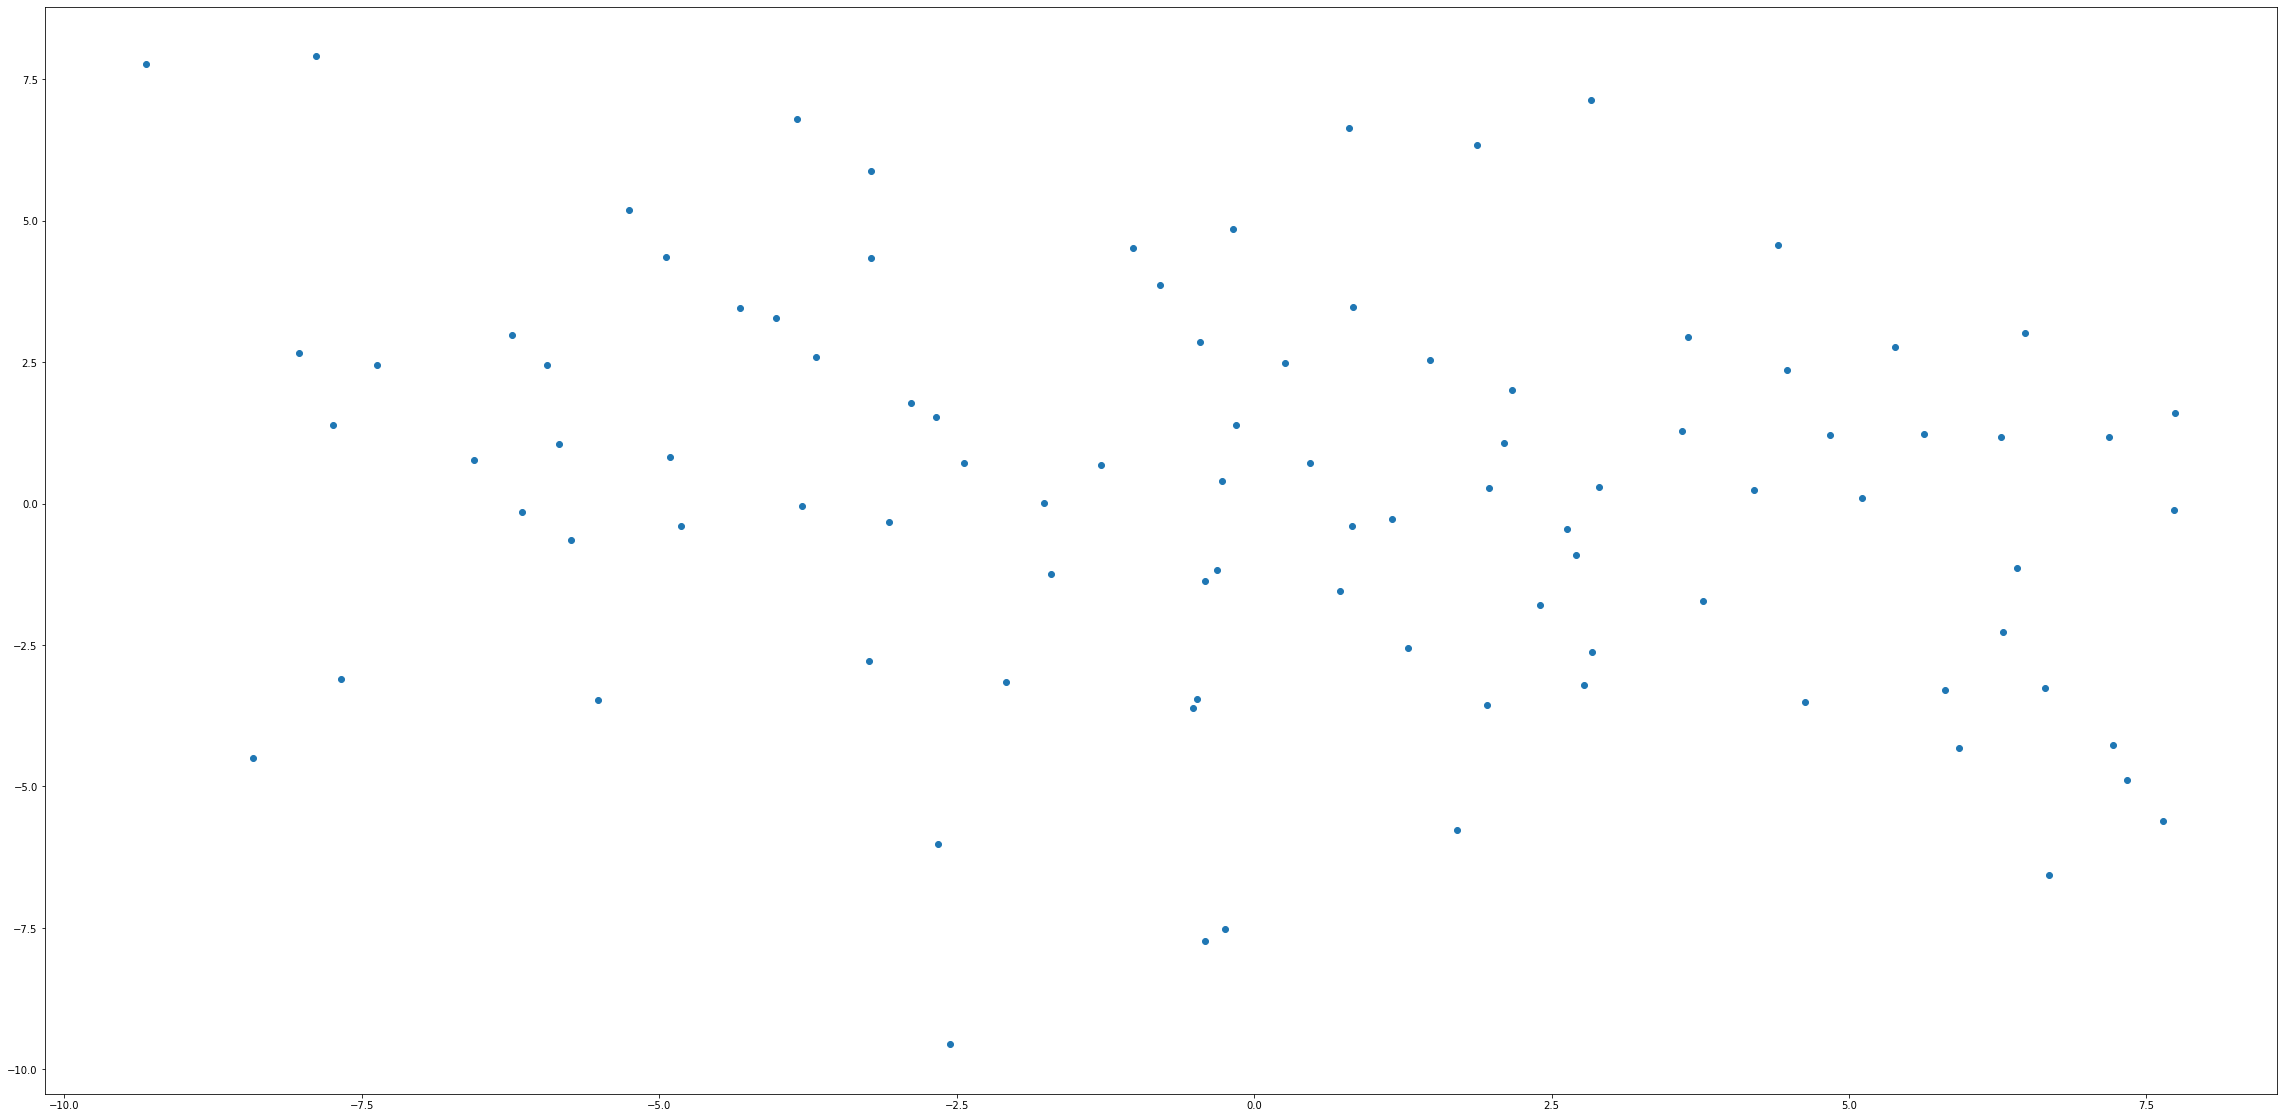

In [22]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:00<00:00, 16.91it/s]


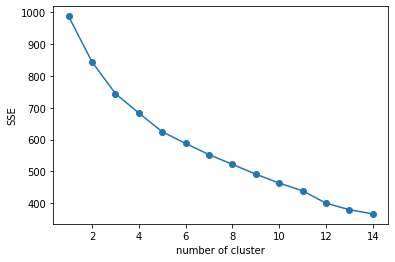

In [23]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [24]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

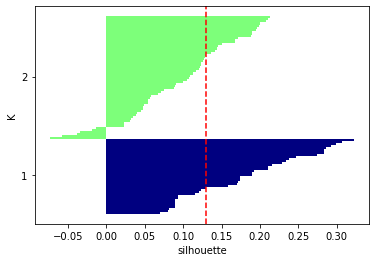

In [25]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

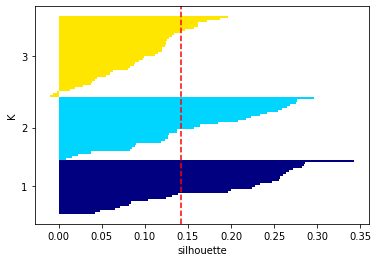

In [26]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

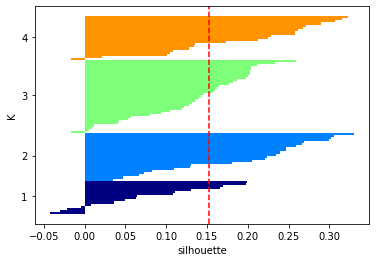

In [27]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

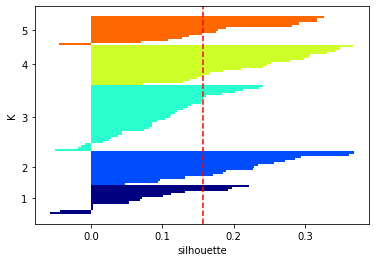

In [28]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

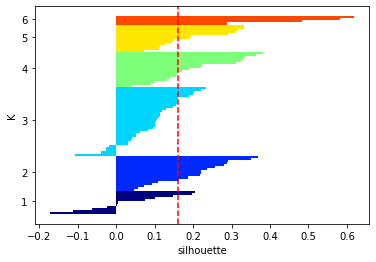

In [29]:
word_vectors = gender['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [30]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [31]:
gender['category'].value_counts()

2    39
0    21
3    19
1    16
Name: category, dtype: int64

In [32]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [33]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [34]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [35]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [36]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-27 00:01:01,295 : INFO : Generating new fontManager, this may take some time...
2020-09-27 00:01:02,230 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-27 00:01:02,346 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-27 00:01:02,513 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str


In [38]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
gender_g5 = gender[gender['category'] == 4]
# gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [39]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
gender_g5_tokens = total_tokens(gender_g5['tokens'])
# gender_g6_tokens = total_tokens(gender_g6['tokens'])

In [45]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고', '대안','대표발의','국회','문장','신설','위원회','국민','임시회','법률안','회부',
            '규정','항제']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
# gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]

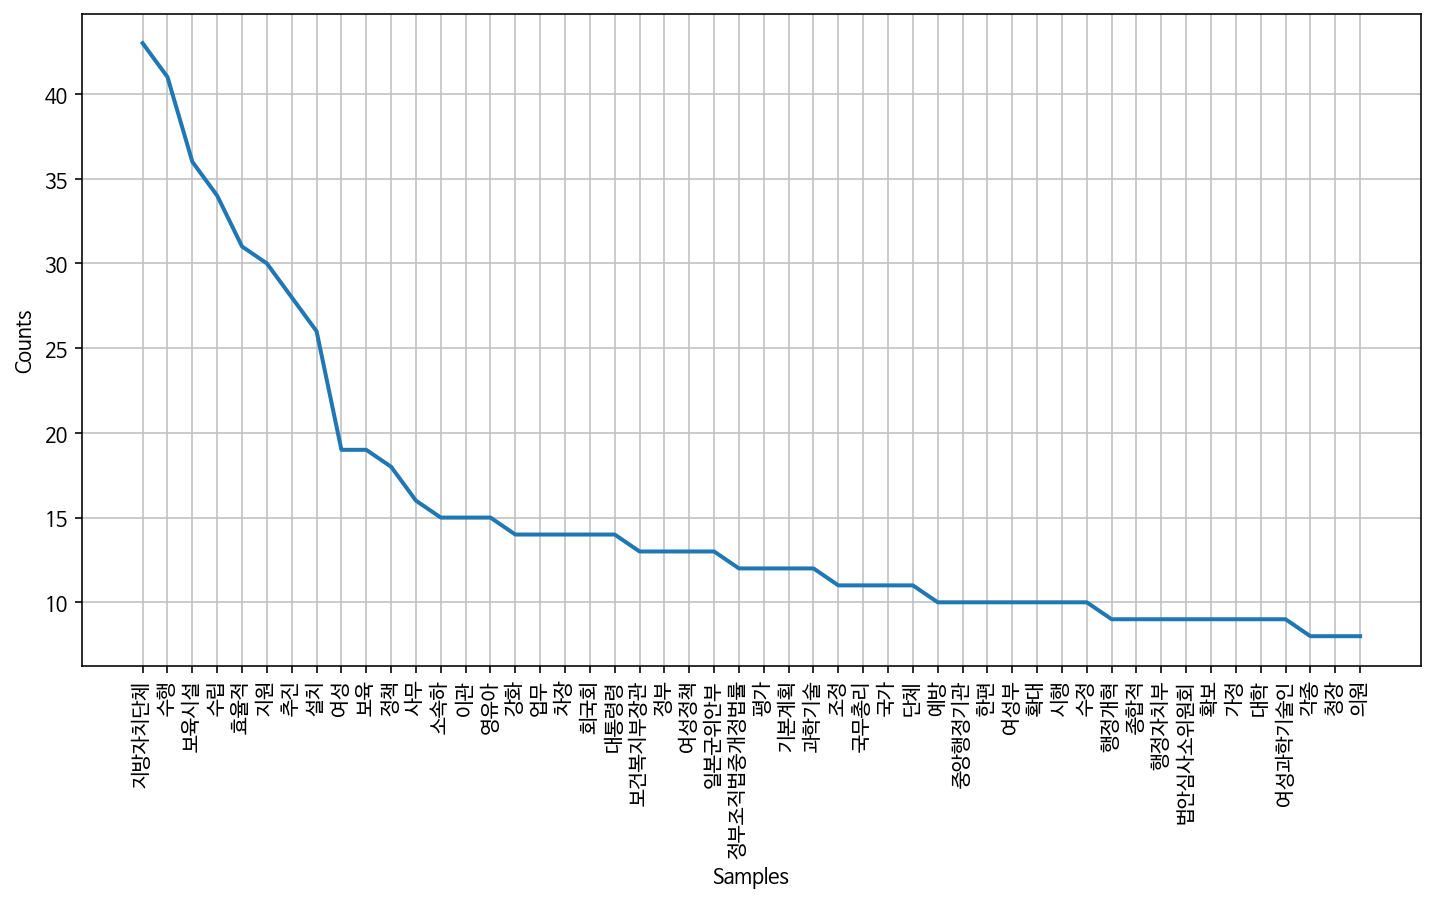

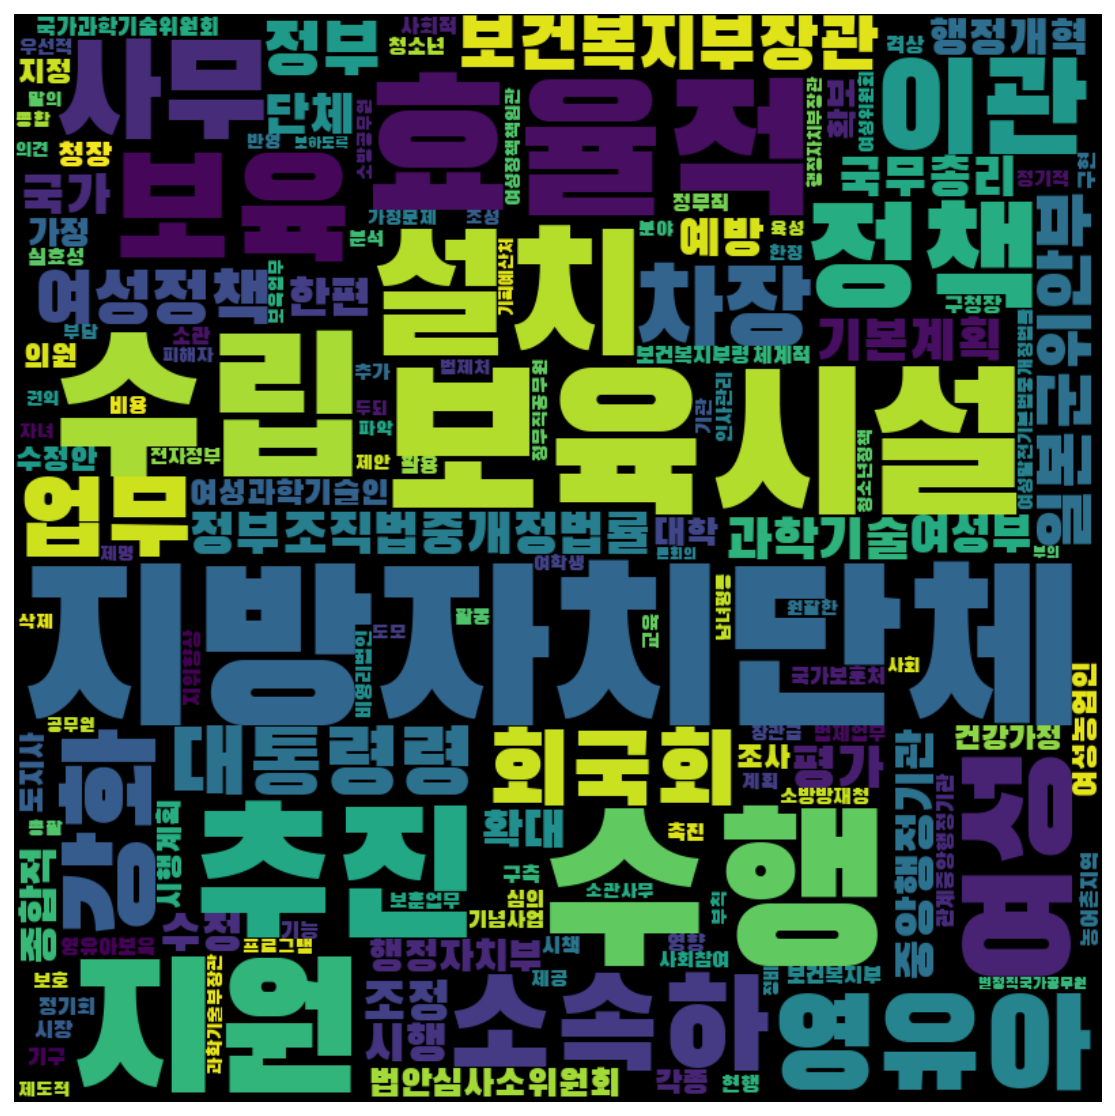

In [46]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

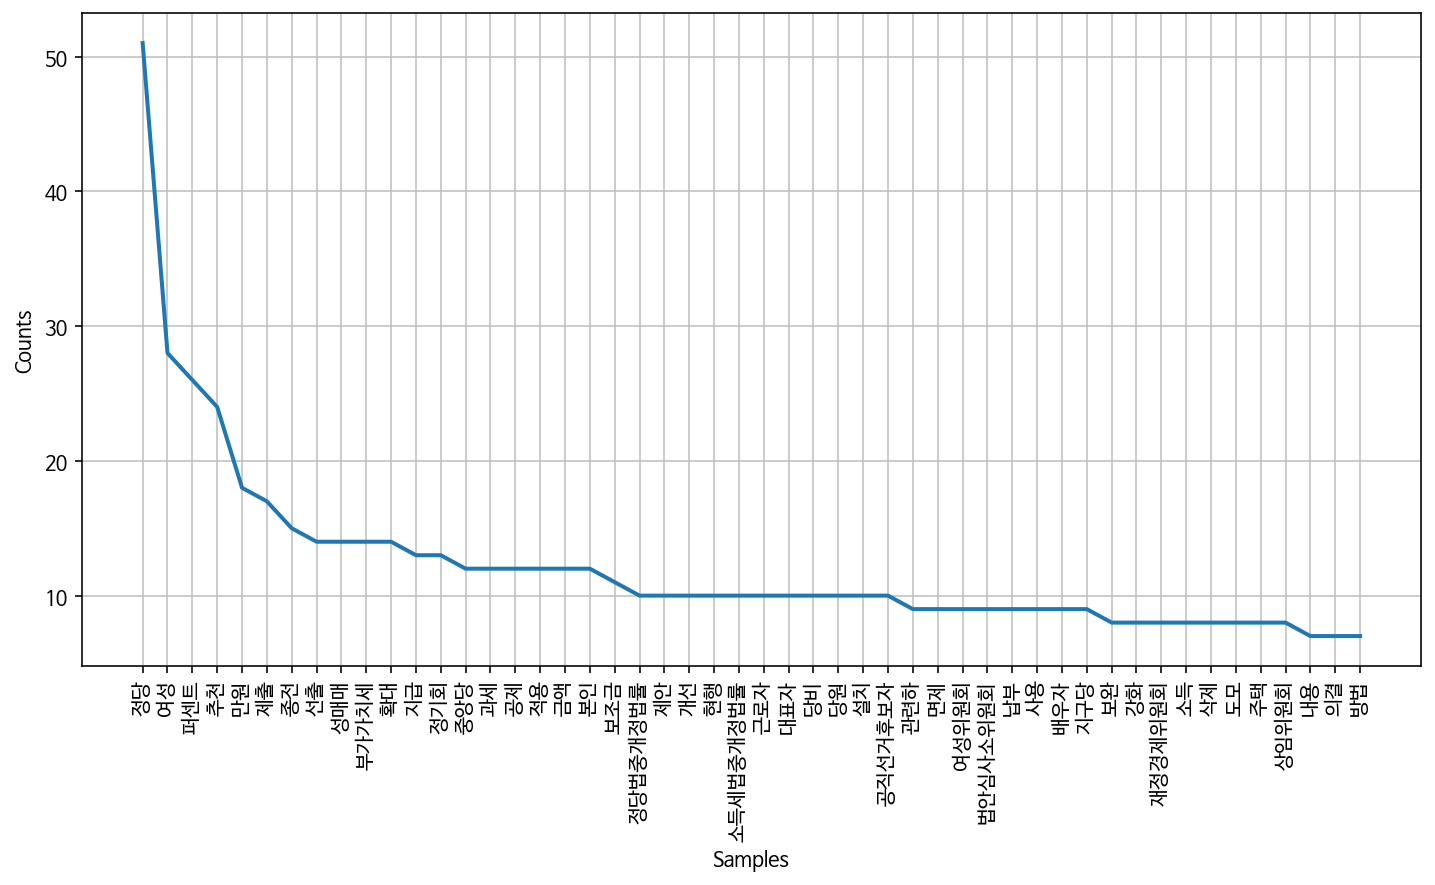

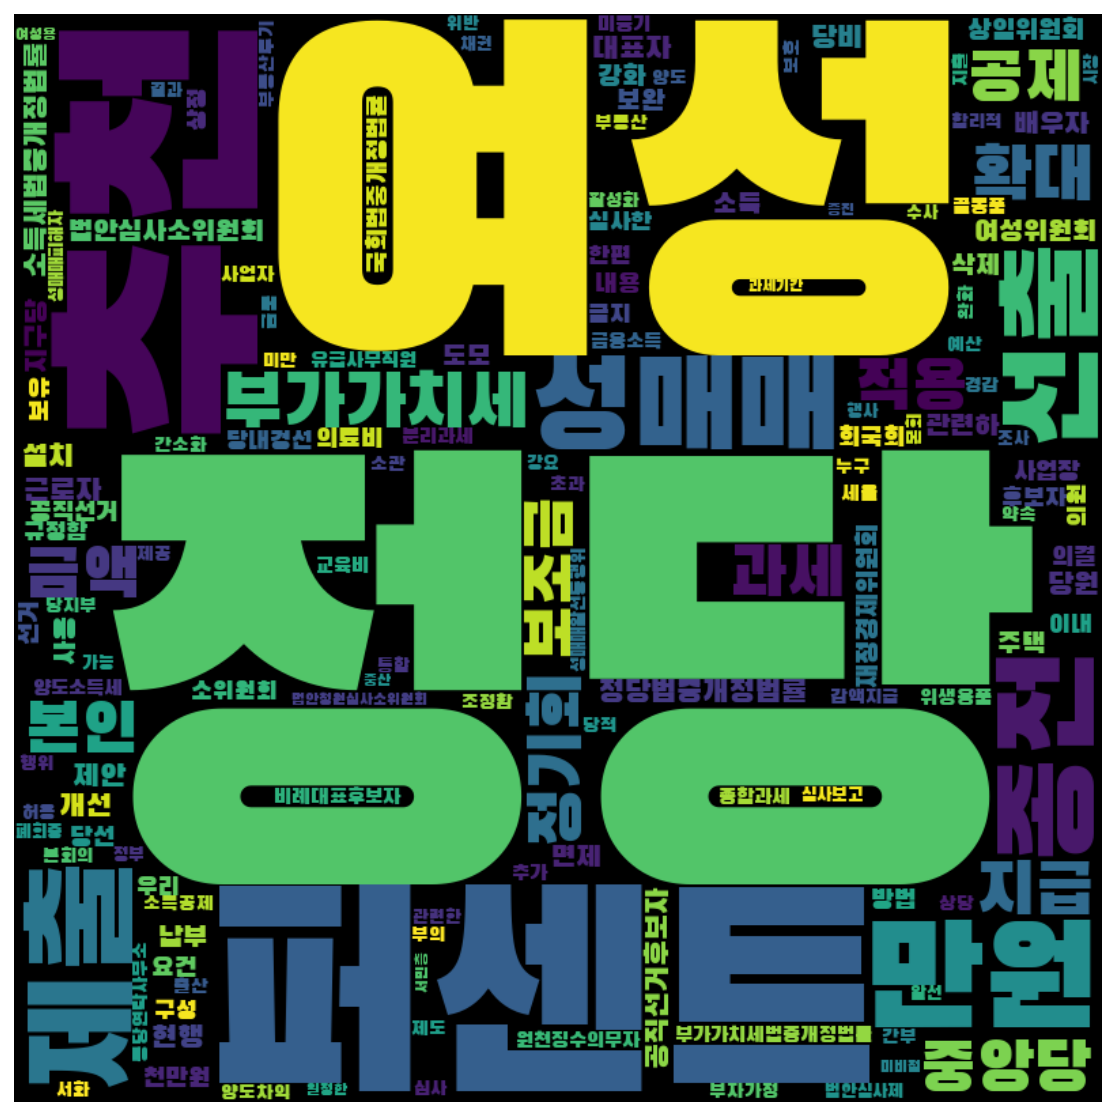

In [47]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

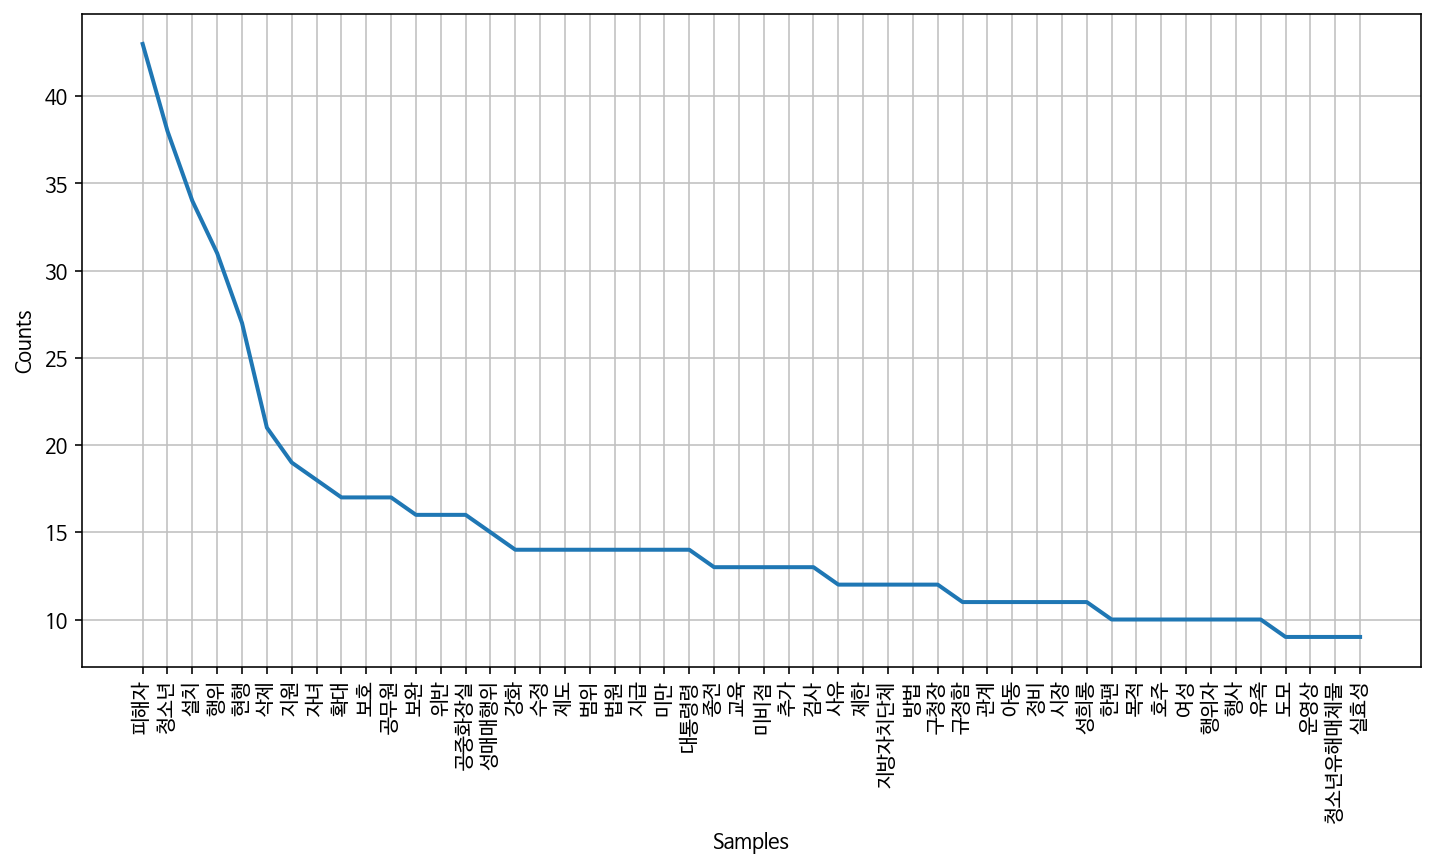

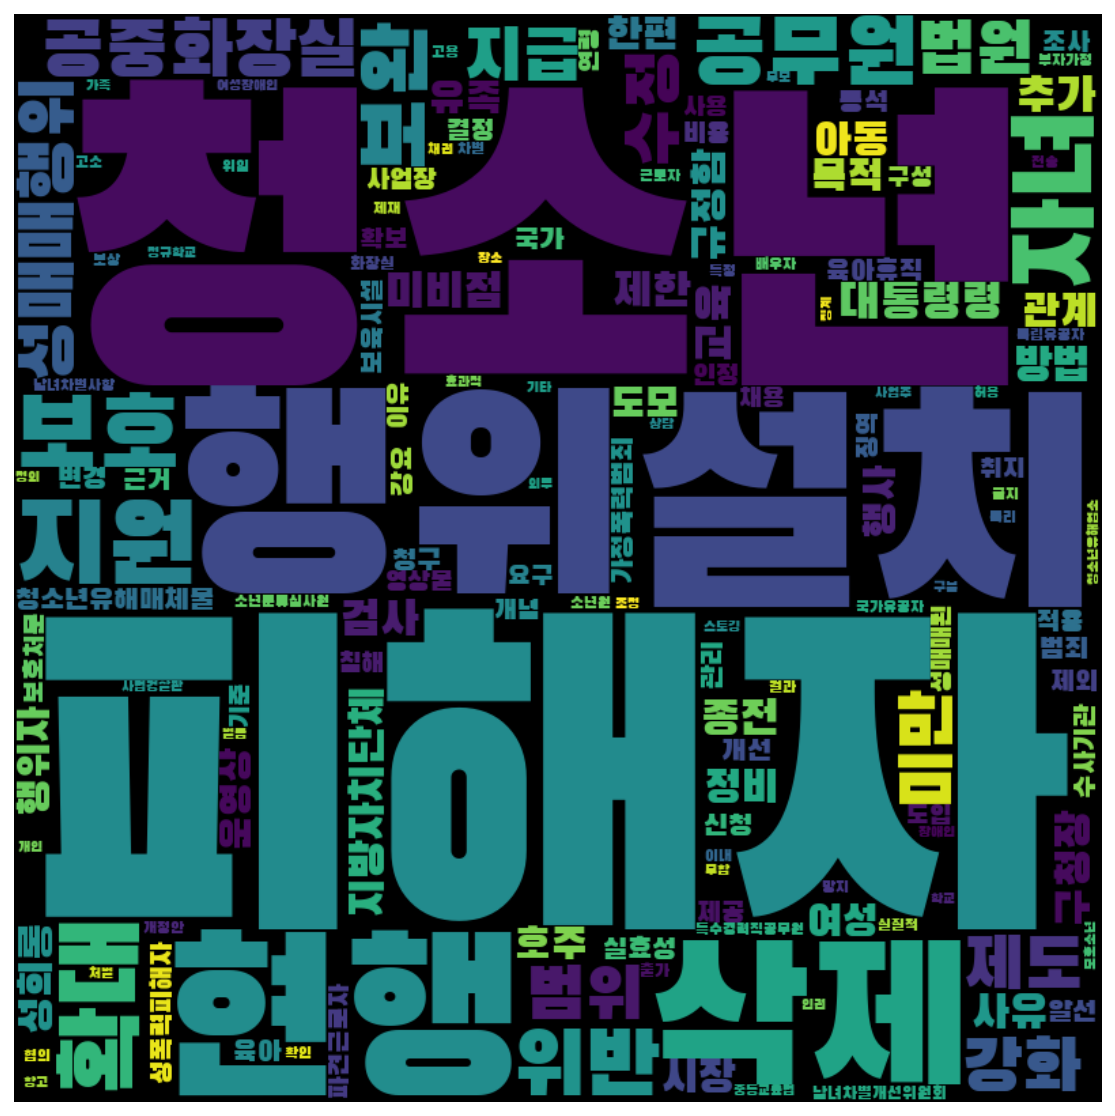

In [48]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

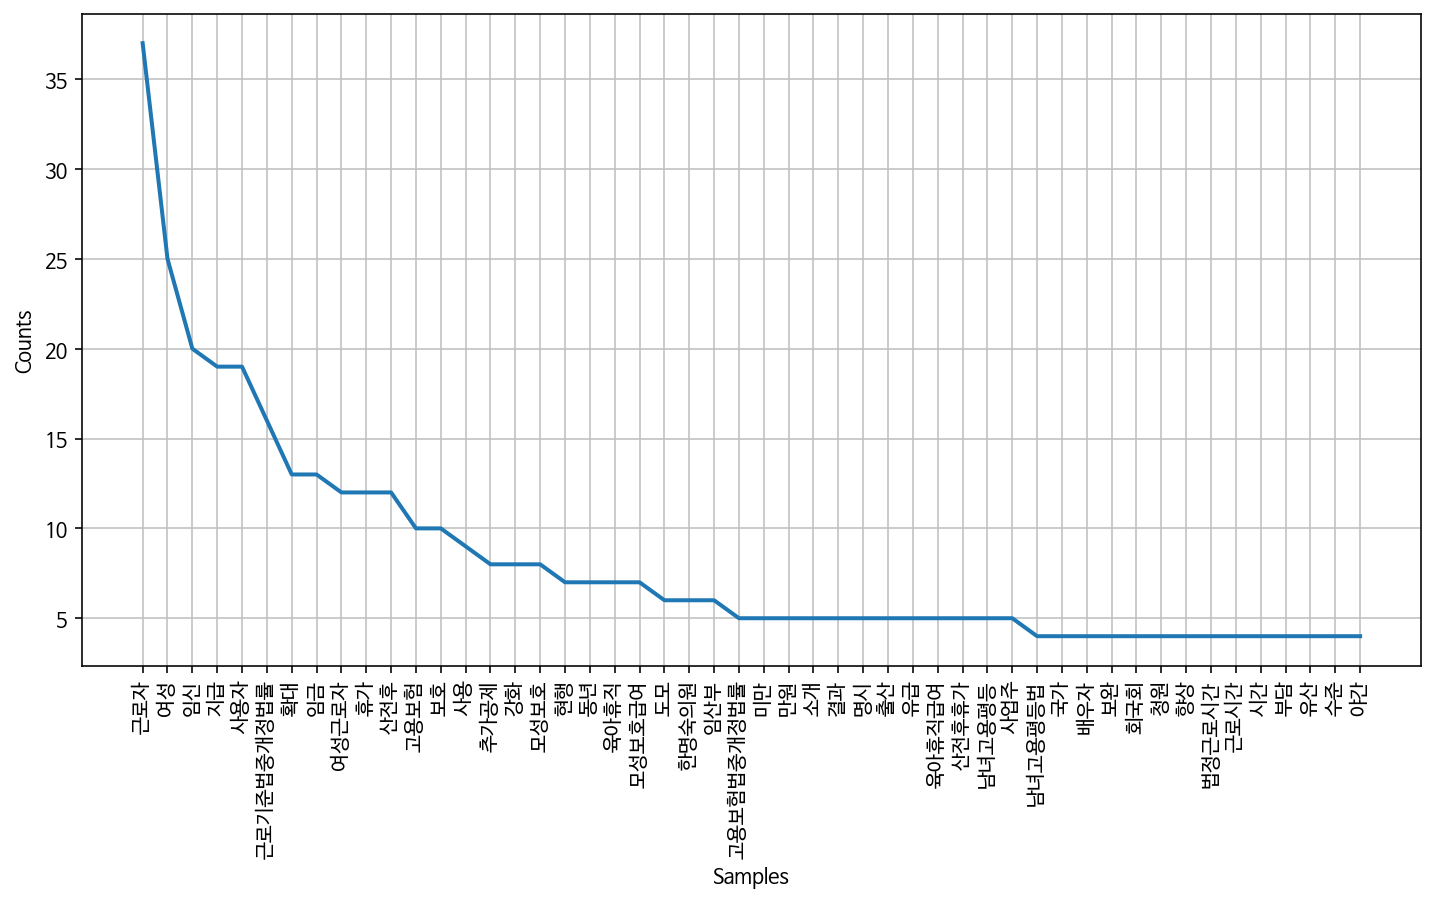

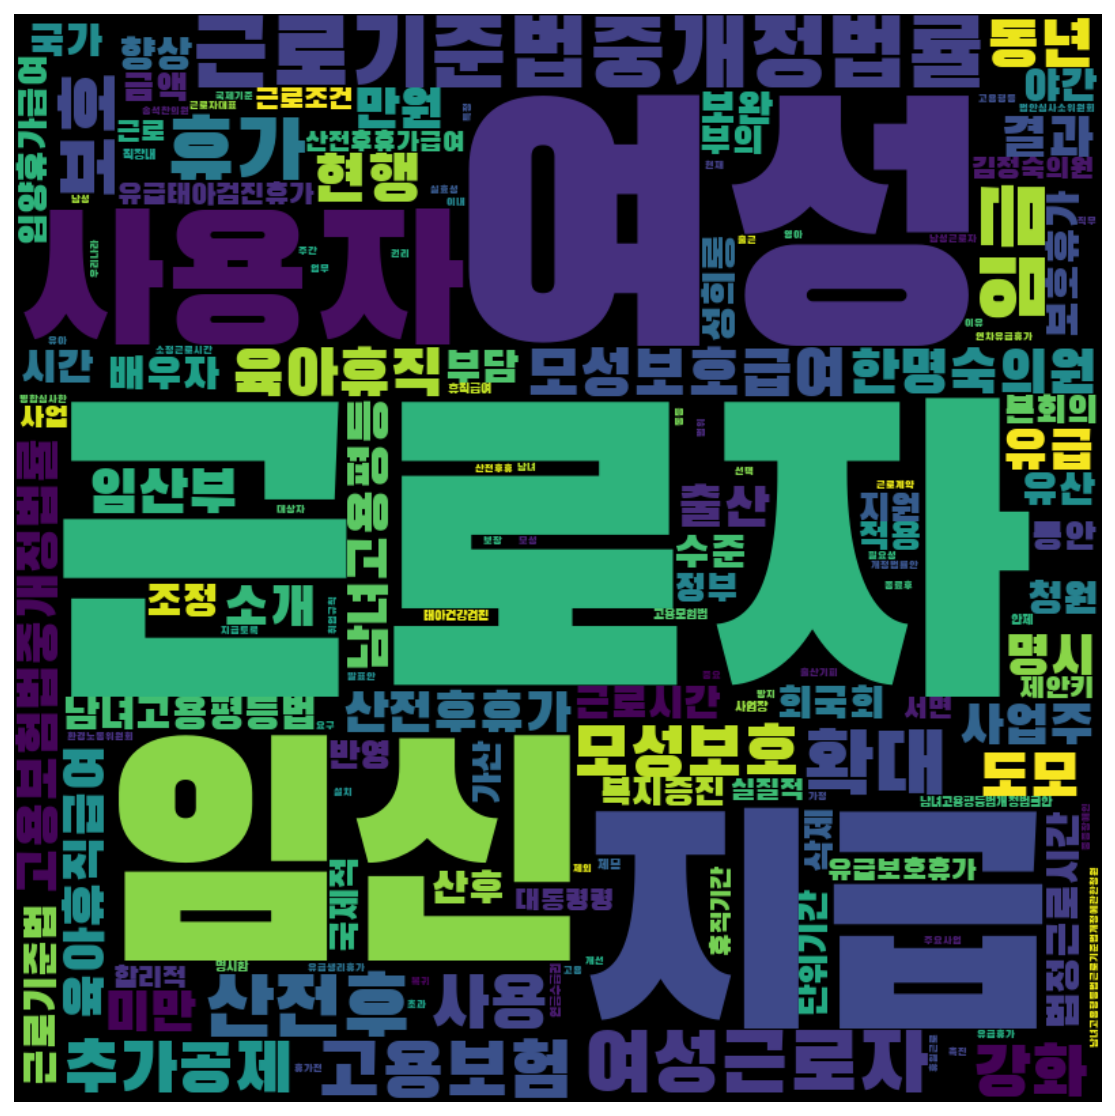

In [49]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


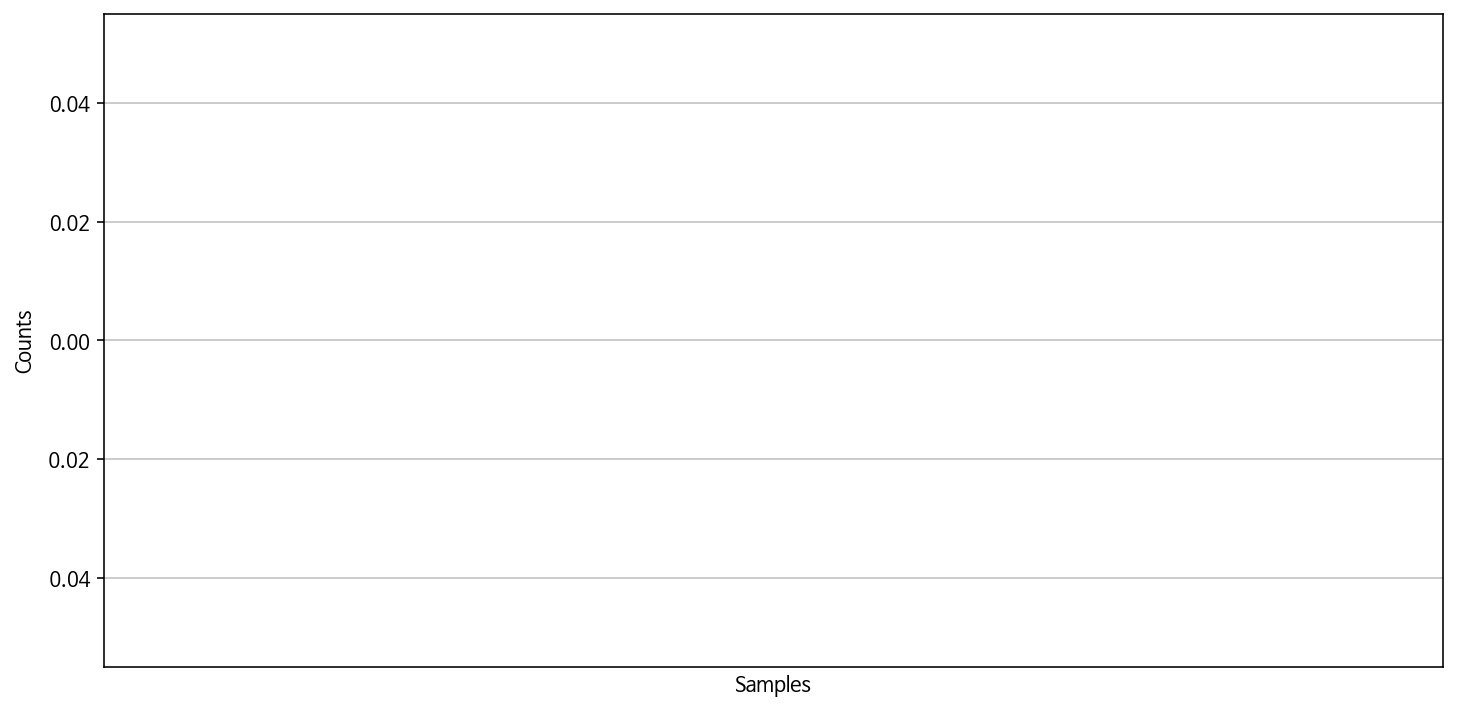

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [43]:
# frewords_vis(gender_g5_tokens)
# wordcloud_vis(gender_g5_tokens)

In [70]:
# frewords_vis(gender_g6_tokens)
# wordcloud_vis(gender_g6_tokens)